In [1]:
from glob import glob
substitles_paths = sorted(glob("/kaggle/input/narutosubtitle/Subtitles/*.ass"))

In [2]:
substitles_paths[:5]

['/kaggle/input/narutosubtitle/Subtitles/Naruto Season 1 - 01.ass',
 '/kaggle/input/narutosubtitle/Subtitles/Naruto Season 1 - 02.ass',
 '/kaggle/input/narutosubtitle/Subtitles/Naruto Season 1 - 03.ass',
 '/kaggle/input/narutosubtitle/Subtitles/Naruto Season 1 - 04.ass',
 '/kaggle/input/narutosubtitle/Subtitles/Naruto Season 1 - 05.ass']

In [3]:
import re

scripts = []
episode_num = []
for path in substitles_paths:
    try:
        with open(path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            lines = lines[27:]
            rows = [",".join(line.split(',')[9:]) for line in lines]
        rows = [line.replace("\\N", ' ') for line in rows]
        script = " ".join(rows)
        
        # Use regex to extract the episode number from the filename
        match = re.search(r'(\d{2})\.ass$', path.split('\\')[-1])
        if match:
            episode = int(match.group(1))
        else:
            print(f"Episode number not found in path: {path}")
            episode = None
        
        scripts.append(script)
        episode_num.append(episode)
    except UnicodeDecodeError:
        print(f"UnicodeDecodeError: Unable to read {path} with utf-8 encoding.")
        continue

In [4]:
import pandas as pd
df = pd.DataFrame.from_dict({'episode':episode_num,'script':scripts})
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."
...,...,...
213,16,"Summoning Jutsu!\n Oh, long time no see.\n We ..."
214,17,Gaara.\n Kankuro.\n Gaara.\n Primary Lotus!\n ...
215,18,To think the Leaf’s reinforcements will be you...
216,19,"Fly into the wavy and twisted sky, into your h..."


In [5]:
df.iloc[5]['script']

'C\'mon!\n Running like a fugitive,\n Being chased by something\n Inside my heart is pounding\n My throat dry like it\'s withering\n For no single one,\n To none does belong,\n This time is ours, right now...\n Unraveling the pain,\n Unraveling our hearts,\n Unraveling shadows\n Stifling our breath,\n Reaching for beyond,\n Tearing through the dark\n In fighting and in love\n To the distant light above,\n Yes, we are on the way\n I wanna rock...\n Rockin\' my heart\n Sasuke here at Point B!\n Sakura here at Point C!\n Naruto here. I\'m at Point A!\n You\'re slow, Naruto!\n Okay, the seventh squad…\n Hm?!\n The target has moved!\n Follow it!\n Alright! It\'s over there!\n What\'s your distance from the target?\n Five meters! I can go at anytime!\n I\'m ready, too!\n Me, too…!\n Okay…\n Do it!\n Uryaaah!\n I got him!\n Does he have the ribbon on his right ear…?\n Are you sure it\'s our target Tora?\n It\'s the target, no mistake.\n Alright, the mission to capture lost pet "Tora" is compl

In [28]:
import spacy
import spacy
print(spacy.info())
nlp = spacy.load("en_core_web_lg")

{'spacy_version': '3.8.2', 'location': '/opt/conda/lib/python3.10/site-packages/spacy', 'platform': 'Linux-5.15.154+-x86_64-with-glibc2.31', 'python_version': '3.10.14', 'pipelines': {'en_core_web_sm': '3.8.0', 'en_core_web_lg': '3.8.0'}}


In [29]:
doc = nlp("Mark went to Germany")
for ent in doc.ents: 
    print(ent.text,ent.label_)

Mark PERSON
Germany GPE


In [30]:
from nltk import sent_tokenize

def get_ners(script):
    script_sentences = sent_tokenize(script)

    ner_output = []
    
    for sentence in script_sentences:
        doc = nlp(sentence)
        ners = set()
        for ent in doc.ents: 
            if ent.label_=='PERSON':
                full_name = ent.text
                first_name=full_name.split(' ')[0]
                ners.add(first_name)
        ner_output.append(list(ners))
    return ner_output

In [33]:
df['ners'] = df['script'].apply(get_ners)

In [34]:
window = 11
entity_relationship = []
for row in df['ners']:
    previous_entities_in_window = []
    for sentence in row:
        previous_entities_in_window.append(sentence)
        previous_entities_in_window = previous_entities_in_window[-window:]
        previous_entities_flattened = sum(previous_entities_in_window, [])
        for entity in sentence:
            for entity_in_window in previous_entities_flattened:
                if entity != entity_in_window:
                    entity_rel = sorted([entity, entity_in_window])
                    entity_relationship.append(entity_rel)

In [35]:
relationship_df = pd.DataFrame({'value':entity_relationship})
relationship_df['source'] = relationship_df['value'].apply(lambda x: x[0])
relationship_df['target'] = relationship_df['value'].apply(lambda x: x[1])
relationship_df = relationship_df.groupby(['source','target']).count().reset_index()
relationship_df = relationship_df.sort_values('value',ascending=False)
relationship_df.head()

,source,target,value
2075,Naruto,Sasuke,708
2071,Naruto,Sakura,371
2399,Sakura,Sasuke,363
1091,Hinata,Naruto,298
77,Akamaru,Kiba,205


In [47]:
relationship_df = relationship_df.head(200)

In [48]:
import networkx as nx
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

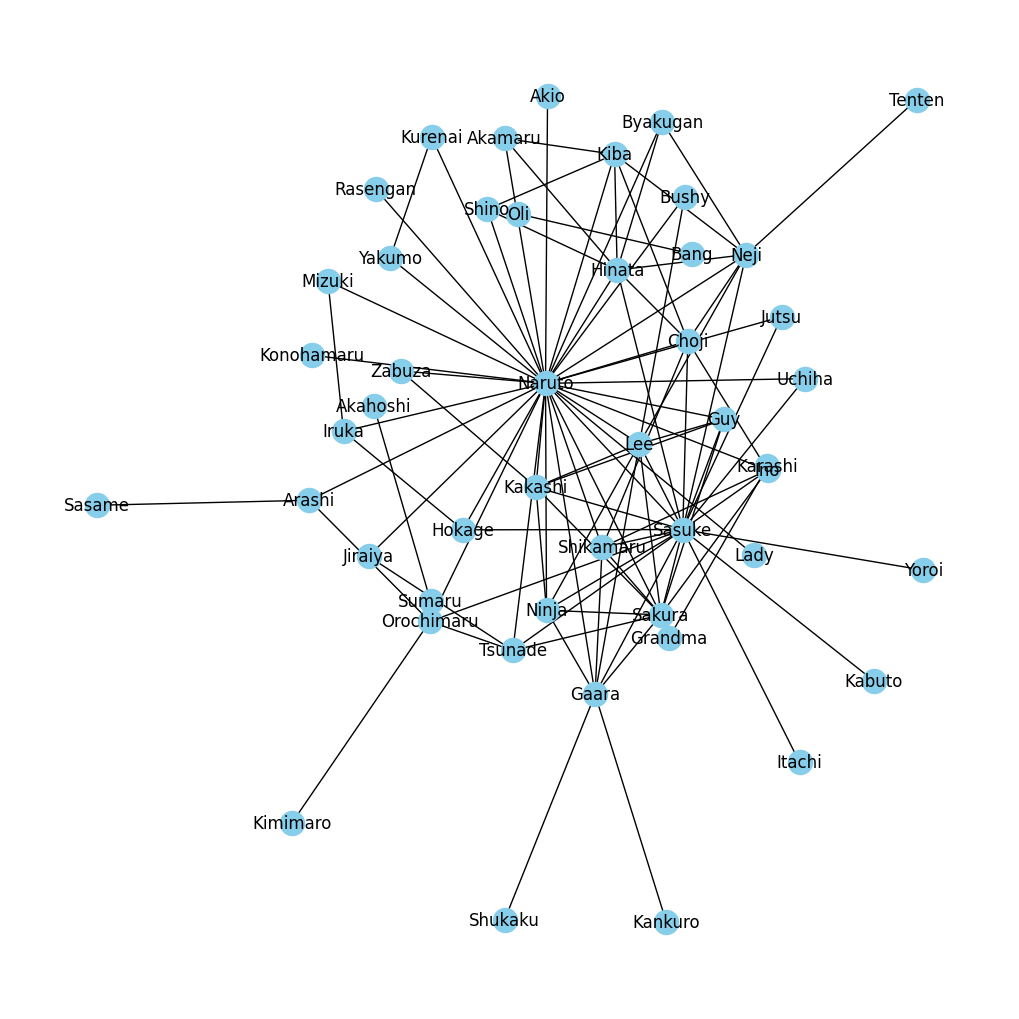

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("naruto.html")